In [3]:
from trulens_eval.tests.test_cases import generate_summeval_groundedness_golden_set


# generator for groundedness golden set
test_cases_gen = generate_summeval_groundedness_golden_set("../../trulens_eval/tests/datasets/summeval/summeval_test_100.json")

In [4]:
test_split, train_split, val_split = [], [] ,[]


for i in range(500):
    test_split.append(next(test_cases_gen))
    
for i in range(500, 1300):
    train_split.append(next(test_cases_gen))

for i in range(1300, 1600):
    val_split.append(next(test_cases_gen))

In [5]:
train_split[:3]

[{'query': "Esteban Cambiasso has won all the major European competitions a player can during his illustrious career but revealed that keeping Leicester City in the Premier League would be up there with the best. The Foxes are currently seven points adrift at the bottom of the table, with only eight games remaining, knowing that time is running out to save themselves. Cambiasso refuses to give up and admits that keeping Leicester up will feel like winning a trophy. Esteban Cambiasso says that helping keep Leicester in the Premier League will feel like winning a trophy 'For me, it's like another cup,' he told BBC East Midlands Today. 'When you start another season you have an objective, and this is the objective for us. 'For me, winning a cup or winning the league with another team is the same now as having the possibility to save Leicester in the Premier League.' The Argentinian midfielder poses with the trophy after his team won the 2010 FIFA Club World Cup Cambiasso had an illustriou

In [28]:
import os
os.environ["SNOWFLAKE_ACCOUNT"] = "xxx-xxx"
os.environ["SNOWFLAKE_USER"] = "..."
os.environ["SNOWFLAKE_USER_PASSWORD"] = "..."
os.environ["OPENAI_API_KEY"] = "sk-..."
os.environ["SNOWFLAKE_DATABASE"] = "..."
os.environ["SNOWFLAKE_SCHEMA"] = "..."

# Extract current prompts we use for groundedness without COT for supervised fine-tuning datasets


In [6]:
from trulens_eval.feedback import prompts

system_prompt: str = prompts.LLM_GROUNDEDNESS_SYSTEM


In [7]:
preprocessed_train_data, preprocessed_val_data = [], []
for row in train_split:
    source, hypothesis = row['query'], row['response']
    user_prompt: str = """
        SOURCE: {source}
        
        Hypothesis: {hypothesis}
        Please answer with just the score. nothing else.
        """.format(
                source=f"{source}", hypothesis=f"{hypothesis}"
        )
    llm_messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}]

    full_prompt = str(llm_messages)
    
    human_score_scale_on_5 = row['human_score']
    human_score_scale_on_10 = 10 * ((human_score_scale_on_5 - 1) / 4)
    
    preprocessed_train_data.append({'prompt': full_prompt, 'completion': str(human_score_scale_on_10)})
    
for row in val_split:
    source, hypothesis = row['query'], row['response']
    user_prompt: str = """
        SOURCE: {source}
        
        Hypothesis: {hypothesis}
        Please answer with just the score. nothing else.
        """.format(
                source=f"{source}", hypothesis=f"{hypothesis}"
        )
    llm_messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}]

    full_prompt = str(llm_messages)
    
    human_score_scale_on_5 = row['human_score']
    human_score_scale_on_10 = 10 * ((human_score_scale_on_5 - 1) / 4)
    
    preprocessed_val_data.append({'prompt': full_prompt, 'completion': str(human_score_scale_on_10)})

assert(len(preprocessed_train_data) == len(train_split))
assert(len(preprocessed_val_data) == len(val_split))
    

In [8]:
preprocessed_train_data[:3]


[{'prompt': '[{\'role\': \'system\', \'content\': \'You are a INFORMATION OVERLAP classifier; providing the overlap of information between the source and statement.\\n        Respond only as a number from 0 to 10 where 0 is no information overlap and 10 is all information is overlapping.\\n        Never elaborate.\'}, {\'role\': \'user\', \'content\': "\\n        SOURCE: Esteban Cambiasso has won all the major European competitions a player can during his illustrious career but revealed that keeping Leicester City in the Premier League would be up there with the best. The Foxes are currently seven points adrift at the bottom of the table, with only eight games remaining, knowing that time is running out to save themselves. Cambiasso refuses to give up and admits that keeping Leicester up will feel like winning a trophy. Esteban Cambiasso says that helping keep Leicester in the Premier League will feel like winning a trophy \'For me, it\'s like another cup,\' he told BBC East Midlands T

# Preparing dataset for Snowflake table - only 2 column names are `prompt` and `completion` are accepted by Cortex Finetuning function

In [ ]:
import snowflake.connector

# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.environ["SNOWFLAKE_USER"],
    password=os.environ["SNOWFLAKE_USER_PASSWORD"],
    account=os.environ["SNOWFLAKE_ACCOUNT"]
)

# Create a cursor object
cur = conn.cursor()

cur.execute("USE DATABASE DHUANG_LLM")
# SQL command to create the table
create_table_sql_train = """
CREATE TABLE IF NOT EXISTS summeval_train_data (
    prompt STRING,
    completion STRING
);
"""
create_table_sql_val = """
CREATE TABLE IF NOT EXISTS summeval_val_data (
    prompt STRING,
    completion STRING
);
"""
# Execute the SQL command to create the table
cur.execute(create_table_sql_train)
cur.execute(create_table_sql_val)

# Data to be inserted

# Insert data into the table
insert_sql_train = "INSERT INTO summeval_train_data (prompt, completion) VALUES (%s, %s)"
for row in preprocessed_train_data:
    cur.execute(insert_sql_train, (row['prompt'], row['completion']))
    
insert_sql_val = "INSERT INTO summeval_val_data (prompt, completion) VALUES (%s, %s)"
for row in preprocessed_val_data:
    cur.execute(insert_sql_val, (row['prompt'], row['completion']))
    
# Commit the transaction
conn.commit()

# Close the cursor and connection
cur.close()
conn.close()


# Kick off Cortex FineTune Job in your Snowflake account to fine-tune `Mixtral-8x7b` (as a feedback function provider)

In [ ]:
import snowflake.connector

# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.environ["SNOWFLAKE_USER"],
    password=os.environ["SNOWFLAKE_USER_PASSWORD"],
    account=os.environ["SNOWFLAKE_ACCOUNT"],
)

# Create a cursor object
cur = conn.cursor()

cur.execute("USE DATABASE DHUANG_LLM")

finetune_sql = """

SELECT SNOWFLAKE.CORTEX.FINETUNE(
  'CREATE',
  'ft_mixtral_8x7b_06152024',
  'mixtral-8x7b',
  'SELECT prompt, completion FROM summeval_train_data',
  'SELECT prompt, completion FROM summeval_val_data'
);
"""

cur.execute(finetune_sql)


# Commit the transaction
conn.commit()

# Close the cursor and connection
cur.close()
conn.close()

# Evaluate the base models to establish baseline performance

In [9]:
test_split[:3]

[{'query': '(CNN)Donald Sterling\'s racist remarks cost him an NBA team last year. But now it\'s his former female companion who has lost big. A Los Angeles judge has ordered V. Stiviano to pay back more than $2.6 million in gifts after Sterling\'s wife sued her. In the lawsuit, Rochelle "Shelly" Sterling accused Stiviano of targeting extremely wealthy older men. She claimed Donald Sterling used the couple\'s money to buy Stiviano a Ferrari, two Bentleys and a Range Rover, and that he helped her get a $1.8 million duplex. Who is V. Stiviano? Stiviano countered that there was nothing wrong with Donald Sterling giving her gifts and that she never took advantage of the former Los Angeles Clippers owner, who made much of his fortune in real estate. Shelly Sterling was thrilled with the court decision Tuesday, her lawyer told CNN affiliate KABC. "This is a victory for the Sterling family in recovering the $2,630,000 that Donald lavished on a conniving mistress," attorney Pierce O\'Donnell s

In [10]:
from trulens_eval import Feedback
from trulens_eval.feedback.provider import Cortex
from trulens_eval import TruBasicApp, Feedback, Tru, Select

from trulens_eval.feedback import GroundTruthAgreement

tru = Tru()
tru.reset_database()

In [ ]:


cortex_provider_mixtral = Cortex(model_engine="mixtral-8x7b")

f_groundedness_mixtral = Feedback(cortex_provider_mixtral.groundedness_measure_with_cot_reasons, name='groundedness Mixtral')

def wrapped_groundedness_mixtral(input, output) -> float:
    score = f_groundedness_mixtral(input, output)[0]   
    return score
ground_truth = GroundTruthAgreement(test_split)
# Call the numeric_difference method with app and record and aggregate to get the mean absolute error
f_mae = Feedback(ground_truth.mae, name = "Mean Absolute Error").on(Select.Record.calls[0].args.args[0]).on(Select.Record.calls[0].args.args[1]).on_output()


tru_wrapped_groundedness_mixtral = TruBasicApp(wrapped_groundedness_mixtral, app_id = "groundedness Mixtral-8x7b baseline", feedbacks=[f_mae])

for i in range(len(test_split)):
    source = test_split[i]["query"]
    response = test_split[i]["response"]
   
    with tru_wrapped_groundedness_mixtral as recording:
        try:
            tru_wrapped_groundedness_mixtral.app(source, response)
        except Exception as e:
            print(e)

In [ ]:


cortex_provider_mistral_7b = Cortex(model_engine="mistral-7b")

f_groundedness_mistral_7b = Feedback(cortex_provider_mistral_7b.groundedness_measure_with_cot_reasons, name='groundedness Mistral-7b')

def wrapped_groundedness_mistral_7b(input, output) -> float:
    score = f_groundedness_mistral_7b(input, output)[0]   
    return score
ground_truth = GroundTruthAgreement(test_split)
# Call the numeric_difference method with app and record and aggregate to get the mean absolute error
f_mae = Feedback(ground_truth.mae, name = "Mean Absolute Error").on(Select.Record.calls[0].args.args[0]).on(Select.Record.calls[0].args.args[1]).on_output()


tru_wrapped_groundedness_mistral_7b = TruBasicApp(wrapped_groundedness_mistral_7b, app_id = "groundedness Mistral-7b baseline", feedbacks=[f_mae])

for i in range(len(test_split)):
    source = test_split[i]["query"]
    response = test_split[i]["response"]
   
    with tru_wrapped_groundedness_mistral_7b as recording:
        try:
            tru_wrapped_groundedness_mistral_7b.app(source, response)
        except Exception as e:
            print(e)

# Finetune `Mistral 7b`, in additional to `Mixtral-8x7b` for side-by-side comparison

In [22]:
import snowflake.connector

# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.environ["SNOWFLAKE_USER"],
    password=os.environ["SNOWFLAKE_USER_PASSWORD"],
    account=os.environ["SNOWFLAKE_ACCOUNT"],
)

# Create a cursor object
cur = conn.cursor()

cur.execute("USE DATABASE DHUANG_LLM")

finetune_sql = """
SELECT SNOWFLAKE.CORTEX.FINETUNE(
  'CREATE',
  'ft_mistral_7b_06182024',
  'mistral-7b',
  'SELECT prompt, completion FROM summeval_train_data',
  'SELECT prompt, completion FROM summeval_val_data'
);
"""

cur.execute(finetune_sql)


# Commit the transaction
conn.commit()

# Close the cursor and connection
cur.close()
conn.close()

In [11]:
ground_truth = GroundTruthAgreement(test_split)
# Call the numeric_difference method with app and record and aggregate to get the mean absolute error
f_mae = Feedback(ground_truth.mae, name = "Mean Absolute Error").on(Select.Record.calls[0].args.args[0]).on(Select.Record.calls[0].args.args[1]).on_output()


✅ In Mean Absolute Error, input prompt will be set to __record__.calls[0].args.args[0] .
✅ In Mean Absolute Error, input response will be set to __record__.calls[0].args.args[1] .
✅ In Mean Absolute Error, input score will be set to __record__.main_output or `Select.RecordOutput` .


# Evaluate Groundedness performance after finetuning for both `Mixtral-8x7b` and `Mistral-7b`

In [ ]:
cortex_provider_mixtral_ft = Cortex(model_engine="ft_mixtral_8x7b_06152024")

f_groundedness_mixtral_ft = Feedback(cortex_provider_mixtral_ft.groundedness_measure_with_cot_reasons, name='groundedness Mixtral finetuned')

def wrapped_groundedness_mixtral_finetuned(input, output) -> float:
    score = f_groundedness_mixtral_ft(input, output)[0]   
    return score



tru_wrapped_groundedness_mixtral_ft = TruBasicApp(wrapped_groundedness_mixtral_finetuned, app_id = "groundedness Mixtral-8x7b finetuned", feedbacks=[f_mae])

for i in range(len(test_split)):
    source = test_split[i]["query"]
    response = test_split[i]["response"]
   
    with tru_wrapped_groundedness_mixtral_ft as recording:
        try:
            tru_wrapped_groundedness_mixtral_ft.app(source, response)
        except Exception as e:
            print(e)

In [ ]:
cortex_provider_mistral_7b_ft = Cortex(model_engine="ft_mistral_7b_06182024")

f_groundedness_mistral_7b = Feedback(cortex_provider_mistral_7b_ft.groundedness_measure_with_cot_reasons, name='groundedness Mistral-7b finetuned')

def wrapped_groundedness_mistral_7b_finetuned(input, output) -> float:
    score = f_groundedness_mistral_7b(input, output)[0]   
    return score



tru_wrapped_groundedness_mistral_7b_ft = TruBasicApp(wrapped_groundedness_mistral_7b_finetuned, app_id = "groundedness Mistral-7b finetuned", feedbacks=[f_mae])

for i in range(len(test_split)):
    source = test_split[i]["query"]
    response = test_split[i]["response"]
   
    with tru_wrapped_groundedness_mistral_7b_ft as recording:
        try:
            tru_wrapped_groundedness_mistral_7b_ft.app(source, response)
        except Exception as e:
            print(e)

In [24]:
tru.get_leaderboard(app_ids=[])

,Mean Absolute Error,latency,total_cost
app_id,,,
groundedness Mistral-7b finetuned,0.205348,17.739040,0.0
groundedness Mistral-7b baseline,0.115529,17.752033,0.0
groundedness Mixtral-8x7b baseline,0.090823,17.756250,0.0
groundedness Mixtral-8x7b finetuned,0.079025,17.770661,0.0


### Preliminary analysis:


We observe a slight improvements over baseline with Mixtral-8x7b model as our feedback provider. 

Notice in the Mistral-7b case, finetuning on a limited set of training data (800 input-output pairs) actually results in worse performance. This could be attributed to the model overfitting the train set and thus failing to generalize well on the test set. 

In another test run (not shown in this notebook), we also see potentially under-training on Llama3-8B, as the train loss recorded was about 20x of the loss values we got here for Mixtral-7b.

Both of the above scenarios are expected with the current beta (private preview) version of Cortex Fine-Tuning API, and we believe better results can be achieved in the near releases.  



### Sanity check: some Statistical Exploration of the SummEval dataset

In [70]:
avg_score_test, avg_score_val, avg_score_train = 0, 0, 0
test_human_scores, val_human_scores, train_human_scores = [], [], []
for row in test_split:
    avg_score_test += row['human_score']
    test_human_scores.append(row['human_score'])
print(avg_score_test)
avg_score_test = avg_score_test / len(test_split)

for row in val_split:
    avg_score_val += row['human_score']
    val_human_scores.append(row['human_score'])

print(avg_score_val)

avg_score_val = avg_score_val / len(val_split)

for row in train_split:
    avg_score_train += row['human_score']
    train_human_scores.append(row['human_score'])

print(avg_score_train)
avg_score_train = avg_score_train / len(train_split)


print(avg_score_train, avg_score_test, avg_score_val)

2300.6666666666665
1430.0
3725.9999999999986
4.657499999999998 4.601333333333333 4.766666666666667


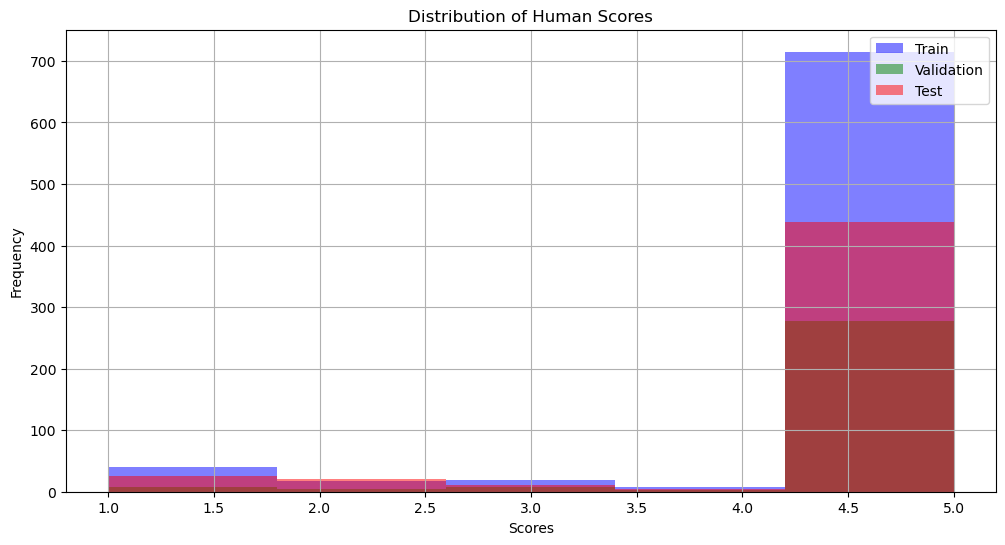

In [71]:
import matplotlib.pyplot as plt



plt.figure(figsize=(12, 6))

plt.hist(train_human_scores, bins=5, alpha=0.5, label='Train', color='b')
plt.hist(val_human_scores, bins=5, alpha=0.5, label='Validation', color='g')
plt.hist(test_human_scores, bins=5, alpha=0.5, label='Test', color='r')

plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Human Scores')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


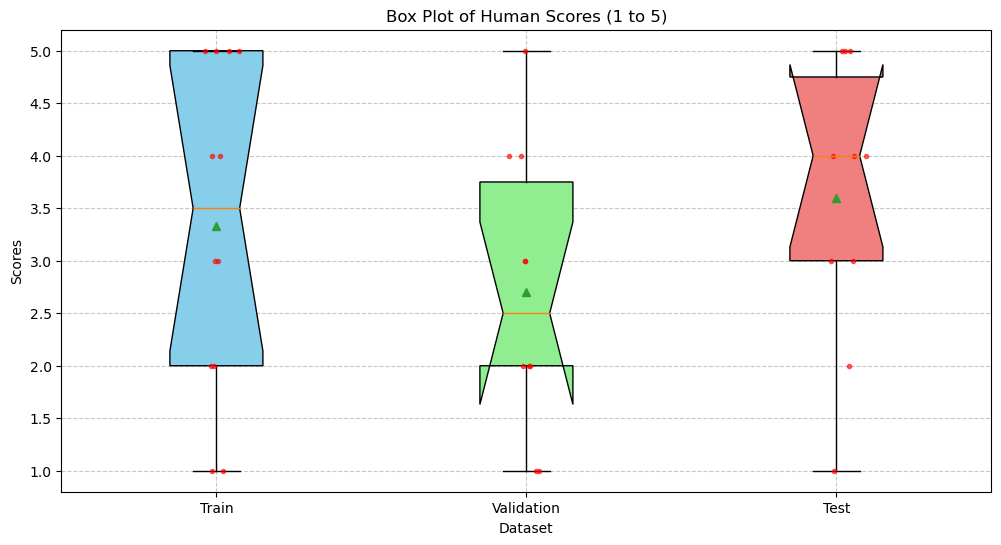

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
train_human_scores = [1, 2, 3, 4, 5, 4, 3, 2, 1, 5, 5, 5]
val_human_scores = [2, 3, 4, 2, 3, 4, 5, 1, 1, 2]
test_human_scores = [3, 4, 5, 3, 2, 1, 4, 5, 5, 4]

# Data for boxplot
data = [train_human_scores, val_human_scores, test_human_scores]
labels = ['Train', 'Validation', 'Test']

plt.figure(figsize=(12, 6))

# Create boxplot
box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True, notch=True)

# Customize boxplot
colors = ['skyblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add jittered points for better visualization of distributions
for i in range(len(data)):
    y = data[i]
    x = np.random.normal(i + 1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.6)

# Axis labels and title
plt.xlabel('Dataset')
plt.ylabel('Scores')
plt.title('Box Plot of Human Scores (1 to 5)')

# Display the plot
plt.show()
